Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

import re
import random

import string

!pip install spacy
!python -m spacy download en
import spacy
from spacy.lang.en import English
import string
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC, NuSVC

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_selection import SelectKBest

from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from xgboost import XGBClassifier

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\en_core_web_sm -->
C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


You do not have sufficient privilege to perform this operation.


In [2]:
# load in the tweets
tweets = pd.read_csv('../data/mercal-btc-tweets-sentiment/data/btc_tweets_daily_example.csv')
tweets.head()

,column_a,date,tweet,screen_name,source,link,sentiment,sent_score,new_sentiment_score,new_sentiment_state
0,0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0,0.000000,0
1,1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0,0.000000,0
2,2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1,0.136364,1
3,3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1,0.400000,1
4,4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1,0.468182,1


In [3]:
# this could be considered a regression or classification problem. We'll go with classification
# majority class baseline
tweets.sent_score.value_counts(normalize=True)

 1    0.450992
 0    0.431369
-1    0.117639
Name: sent_score, dtype: float64

In [4]:
# Dropping unused columns, checking shape

tweets.drop(columns=['column_a','link','sentiment',
             'new_sentiment_score','new_sentiment_state'], inplace=True)

tweets.shape

(50859, 5)

In [5]:
# load in punctuation
punctuations = string.punctuation

# load in stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# instantiate the english parser
parser = English()

# create a function to tokenize and lemmatize tweets, and remove stopwords and punctuation
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [6]:
def clean_text(text): # Clean our tweets using regex. Remove weird characters and links.
    cleanedup = text.lower()
    return re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", cleanedup)

In [7]:
# initialize vectorizers for vectorizing tweets
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [8]:
# clean the tweets, divide into feature and target, divide into train and test

tweets['tweet'] = tweets['tweet'].apply(clean_text)

X = tweets['tweet'] # X 
ylabels = tweets['sent_score'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [9]:
tweets['tweet'][1]

' kevinpham sage  but  dum b a ss said you know nothing about    '

In [10]:
X_train.head(10)

32865                            rt   checkout our        
28973    rt crypto    value 50 followretweet and liketa...
43644           heres why bitcoin is the future of money  
46777    rt  we already have an ios prototype of the be...
45042    rt  let hadoop for dummies help harness the po...
31965    dear   the recent increase of ads for bitcoin ...
2718     rt coin have you ever had the question what is...
42040                         how do i get bitcoin money  
11642    bitcoin today prices retreat from weeks highs ...
22922    rt  today bethereum was featured on cointelegr...
Name: tweet, dtype: object

In [11]:
# another baseline with logistic regression

drop_dimensions = SelectKBest(k=1000)
classifier = LogisticRegression()

# create pipeline using Bag of Words
BoW_logit = Pipeline([
            ('vectorizer', bow_vector),
            ('selector', drop_dimensions),
            ('classifier', classifier)
                ])

# model generation
BoW_logit.fit(X_train,y_train)

C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spac...
                                 vocabulary=None)),
                ('selector',
                 SelectKBest(k=1000,
                             score_func=<function f_classif at 0x00000286F1D5FC18>)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                           

In [12]:
# predict our test
predicted = BoW_logit.predict(X_test)

# get accuracy, precision, recall
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='macro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='macro'))

Logistic Regression Accuracy: 0.8954646742692358
Logistic Regression Precision: 0.9115219199160428
Logistic Regression Recall: 0.8694414375018736


In [14]:
predicted.shape

(15258,)

In [15]:
BoW_logit.steps[2][1].coef_[0].sum()

203.89099553756205

In [18]:
BoW_logit.steps[1][1].inverse_transform(BoW_logit.steps[2][1].coef_)[0]

array([-0.9546683,  0.       ,  0.       , ...,  0.       ,  0.       ,
        0.       ])

In [19]:
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_pred)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]

  table = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred), columns=columns, index=index)
  
  return sns.heatmap(table, annot=True, fmt='d')
  


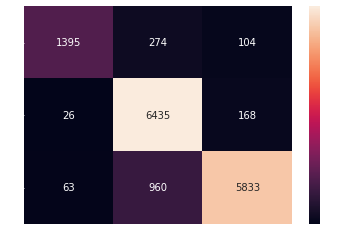

In [20]:
plot_confusion_matrix(y_test, predicted)

In [24]:
all_names = pd.Series(BoW_logit.steps[0][1].get_feature_names())
selected_mask = pd.Series(BoW_logit.steps[1][1].get_support())
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

In [25]:
len(selected_names)

1000

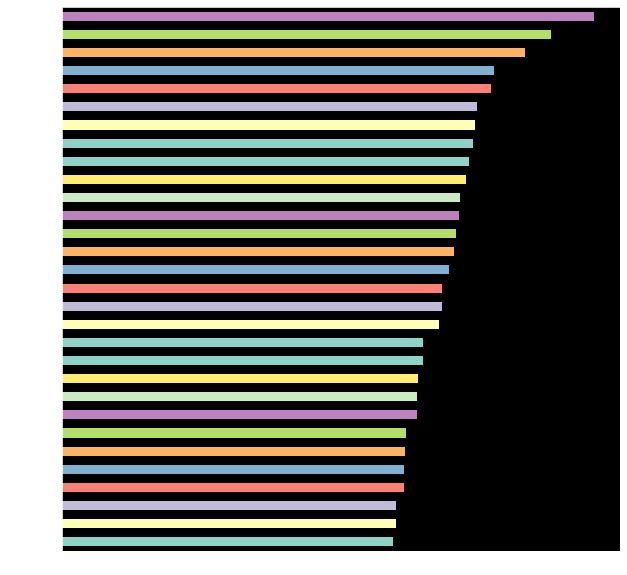

In [28]:
functional_coefficients = pd.Series(
    BoW_logit.steps[2][1].coef_[0],
    selected_names
)

plt.figure(figsize=(10,10))
functional_coefficients.sort_values().tail(30).plot.barh()

In [21]:
BoW_logit.steps[1][1].intercept_

array([-2.94310846,  1.45014329, -1.94546609])

In [29]:
# testing ridge classifier to see if it gives proper coefs
drop_dimensions2 = SelectKBest(k=1000)
ridge = RidgeClassifier()

# create pipeline using Bag of Words
BoW_ridge = Pipeline([
            ('vectorizer', bow_vector),
            ('selector', drop_dimensions2),
            ('classifier', ridge)
                ])

# model generation
BoW_ridge.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x00000286F2826B88>,
                                 vocabulary=None)),
                ('selector',
                 SelectKBest(k=1000,
                             score_func=<function f_classif at 0x00000286F1D5FC18>)),
                ('classifier',
                 RidgeClassifier(alpha=1.0, class_weight=None, copy_X

In [30]:
# predict our test
ridgepredicted = BoW_ridge.predict(X_test)

# get accuracy, precision, recall
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, ridgepredicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, ridgepredicted, average='macro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, ridgepredicted, average='macro'))

Logistic Regression Accuracy: 0.8951369773233714
Logistic Regression Precision: 0.9139447365638381
Logistic Regression Recall: 0.8702656127775903


In [31]:
all_names_ridge = pd.Series(BoW_ridge.steps[0][1].get_feature_names())
selected_mask_ridge = pd.Series(BoW_ridge.steps[1][1].get_support())
selected_names_ridge = all_names_ridge[selected_mask_ridge]
unselected_names_ridge = all_names_ridge[~selected_mask_ridge]

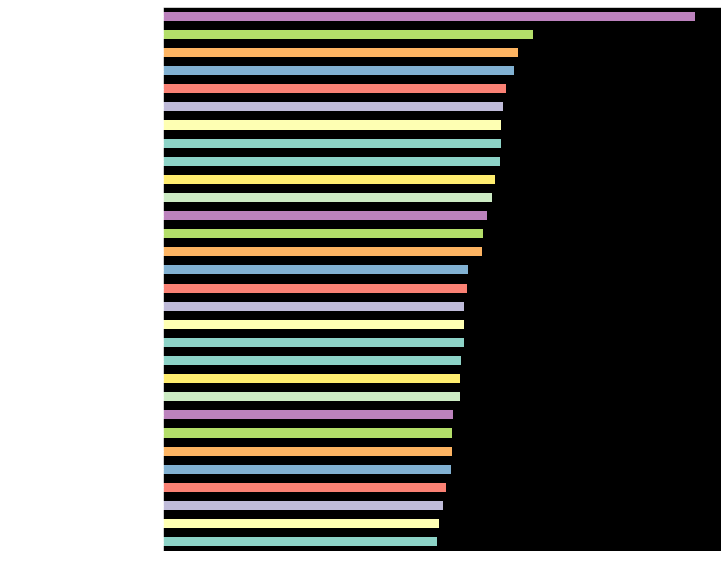

In [33]:
ridge_coefficients = pd.Series(
    BoW_ridge.steps[2][1].coef_[0],
    selected_names
)

plt.figure(figsize=(10,10))
ridge_coefficients.sort_values().tail(30).plot.barh()

In [149]:
BoW_ridge.steps[2][1].intercept_

array([-0.83764639,  0.41899269, -0.5813463 ])

In [35]:
# prepare a pre-BoW'd version of X
BoW_encoder = bow_vector
X_train_BoW = BoW_encoder.fit_transform(X_train)
X_test_BoW = BoW_encoder.transform(X_test)

drop_dimensions3 = SelectKBest(k=50)
X_train_kbest = drop_dimensions3.fit_transform(X_train_BoW,y_train)
X_test_kbest = drop_dimensions3.transform(X_test_BoW)

In [36]:
# evaluation set for early stopping
eval_set = [(X_train_kbest, y_train), 
            (X_test_kbest,y_test)]

In [43]:
# these parameters aren't well-optimized, plenty more work to do.
# I tried out the DART booster... it's very slow.
model = XGBClassifier(
    n_estimators = 15000, # we'll stop short of this thanks to early stopping
    max_depth = 8,
    learning_rate = 0.05,
    #gamma = 0.05,
    #colsample_bytree = 0.3,
    #scale_pos_weight = 0.8,
    booster = 'gbtree',
    n_jobs = -1
)

model.fit(X_train_kbest, y_train, 
          eval_set=eval_set, 
          eval_metric='merror',
         early_stopping_rounds=50)

[0]	validation_0-merror:0.348473	validation_1-merror:0.350308
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.348473	validation_1-merror:0.350374
[2]	validation_0-merror:0.348558	validation_1-merror:0.350439
[3]	validation_0-merror:0.348558	validation_1-merror:0.350439
[4]	validation_0-merror:0.348558	validation_1-merror:0.350439
[5]	validation_0-merror:0.347968	validation_1-merror:0.350046
[6]	validation_0-merror:0.347968	validation_1-merror:0.350046
[7]	validation_0-merror:0.347968	validation_1-merror:0.350046
[8]	validation_0-merror:0.347968	validation_1-merror:0.350046
[9]	validation_0-merror:0.347406	validation_1-merror:0.349784
[10]	validation_0-merror:0.347406	validation_1-merror:0.349784
[11]	validation_0-merror:0.347322	validation_1-merror:0.349718
[12]	validation_0-merror:0.347322	validation_1-merror:0.349718
[13]	validation_0-merror:0.3

[128]	validation_0-merror:0.343895	validation_1-merror:0.346048
[129]	validation_0-merror:0.343895	validation_1-merror:0.346048
[130]	validation_0-merror:0.343895	validation_1-merror:0.346048
[131]	validation_0-merror:0.343895	validation_1-merror:0.346048
[132]	validation_0-merror:0.343895	validation_1-merror:0.346048
[133]	validation_0-merror:0.343895	validation_1-merror:0.346048
[134]	validation_0-merror:0.343754	validation_1-merror:0.345655
[135]	validation_0-merror:0.343754	validation_1-merror:0.345655
[136]	validation_0-merror:0.343754	validation_1-merror:0.345655
[137]	validation_0-merror:0.343754	validation_1-merror:0.345655
[138]	validation_0-merror:0.343754	validation_1-merror:0.345655
[139]	validation_0-merror:0.343754	validation_1-merror:0.345655
[140]	validation_0-merror:0.343754	validation_1-merror:0.345655
[141]	validation_0-merror:0.343754	validation_1-merror:0.345655
[142]	validation_0-merror:0.342884	validation_1-merror:0.344475
[143]	validation_0-merror:0.342884	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=15000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
all_names_XGB = pd.Series(BoW_encoder.get_feature_names())
selected_mask_XGB = pd.Series(drop_dimensions3.get_support())
selected_names_XGB = all_names_XGB[selected_mask_XGB]
unselected_names_XGB = all_names_XGB[~selected_mask_XGB]

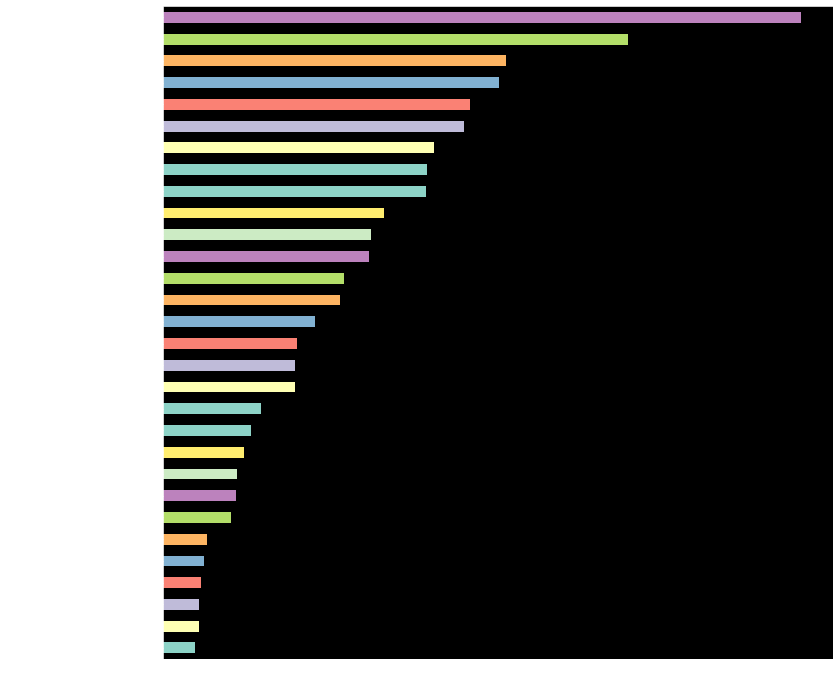

In [47]:
# Feature importances
importances = pd.Series(model.feature_importances_, selected_names_XGB)
importances.sort_values().tail(30).plot.barh(figsize = [12,12])

In [51]:
selected_names_XGB.tolist()

['1000000000volume',
 '1limited',
 '20m4',
 '500',
 'air',
 'airdrop',
 'automatically',
 'best',
 'ceo',
 'change',
 'checkout',
 'click',
 'cloud',
 'collectibles',
 'complete',
 'completing',
 'copy',
 'currency',
 'demanding',
 'difficult',
 'dividend667',
 'dorsey',
 'ethlikeretweetfollowcomment',
 'falls',
 'free',
 'great',
 'half',
 'hour',
 'impossible',
 'jack',
 'livereceive',
 'memberstotal',
 'monthly',
 'new',
 'official',
 'ransom',
 'ready',
 'requires',
 'safeguards',
 'single',
 'successful',
 'supply',
 'tasks',
 'today',
 'traders',
 'traffic',
 'twitter',
 'web',
 'worlds',
 'worthless']

In [54]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=42
)

permuter.fit(X_test_kbest.toarray(), y_test)
feature_names = selected_names_XGB.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

C:\Users\conno\Anaconda3\envs\unit2\lib\site-packages\eli5\formatters\html.py:235: RuntimeWarning: invalid value encountered in double_scalars
  rel_weight = (abs(weight) / weight_range) ** 0.7


Weight,Feature
0 ± 0.0000,worthless
0 ± 0.0000,cloud
0 ± 0.0000,ethlikeretweetfollowcomment
0 ± 0.0000,dorsey
0 ± 0.0000,dividend667
0 ± 0.0000,difficult
0 ± 0.0000,demanding
0 ± 0.0000,currency
0 ± 0.0000,copy
0 ± 0.0000,completing
